In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import math
import sklearn
import sklearn.datasets

from opt_utils import load_params_and_grads, initialize_parameters, forward_propagation, backward_propagation
from opt_utils import compute_cost, predict, predict_dec, plot_decision_boundary, load_dataset
from testCases import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

C:\Users\HP\Documents\ass3\opt_utils.py:76: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(parameters['W' + str(l)].shape == layer_dims[l], layer_dims[l-1])
C:\Users\HP\Documents\ass3\opt_utils.py:77: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(parameters['W' + str(l)].shape == layer_dims[l], 1)


In [2]:
def update_parameters_with_gd(parameters, grads, learning_rate):
    L = len(parameters) // 2 

    for l in range(L):
        parameters["W" + str(l+1)] -= learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] -= learning_rate * grads["db" + str(l+1)]
                
    return parameters

In [4]:
def update_parameters_with_gd_test_case():
    np.random.seed(1)
    learning_rate = 0.01
    W1 = np.random.randn(2,3)
    b1 = np.random.randn(2,1)
    W2 = np.random.randn(3,3)
    b2 = np.random.randn(3,1)

    dW1 = np.random.randn(2,3)
    db1 = np.random.randn(2,1)
    dW2 = np.random.randn(3,3)
    db2 = np.random.randn(3,1)
    
    parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2}
    grads = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}
    
    return parameters, grads, learning_rate


In [5]:
parameters, grads, learning_rate = update_parameters_with_gd_test_case()

parameters = update_parameters_with_gd(parameters, grads, learning_rate)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[ 1.63535156 -0.62320365 -0.53718766]
 [-1.07799357  0.85639907 -2.29470142]]
b1 = [[ 1.74604067]
 [-0.75184921]]
W2 = [[ 0.32171798 -0.25467393  1.46902454]
 [-2.05617317 -0.31554548 -0.3756023 ]
 [ 1.1404819  -1.09976462 -0.1612551 ]]
b2 = [[-0.88020257]
 [ 0.02561572]
 [ 0.57539477]]


In [6]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    np.random.seed(seed)            
    m = X.shape[1]                 
    mini_batches = []

    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1,m))
    num_complete_minibatches = math.floor(m/mini_batch_size) 
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : (k+1) * mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : (k+1) * mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size: ]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size: ]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [8]:
def random_mini_batches_test_case():
    np.random.seed(1)
    mini_batch_size = 64
    X = np.random.randn(12288, 148)
    Y = np.random.randn(1, 148) < 0.5
    return X, Y, mini_batch_size

In [9]:
X_assess, Y_assess, mini_batch_size = random_mini_batches_test_case()
mini_batches = random_mini_batches(X_assess, Y_assess, mini_batch_size)

print ("shape of the 1st mini_batch_X: " + str(mini_batches[0][0].shape))
print ("shape of the 2nd mini_batch_X: " + str(mini_batches[1][0].shape))
print ("shape of the 3rd mini_batch_X: " + str(mini_batches[2][0].shape))
print ("shape of the 1st mini_batch_Y: " + str(mini_batches[0][1].shape))
print ("shape of the 2nd mini_batch_Y: " + str(mini_batches[1][1].shape)) 
print ("shape of the 3rd mini_batch_Y: " + str(mini_batches[2][1].shape))
print ("mini batch sanity check: " + str(mini_batches[0][0][0][0:3]))

shape of the 1st mini_batch_X: (12288, 64)
shape of the 2nd mini_batch_X: (12288, 64)
shape of the 3rd mini_batch_X: (12288, 20)
shape of the 1st mini_batch_Y: (1, 64)
shape of the 2nd mini_batch_Y: (1, 64)
shape of the 3rd mini_batch_Y: (1, 20)
mini batch sanity check: [ 0.90085595 -0.7612069   0.2344157 ]


In [10]:
def initialize_velocity(parameters):   
    L = len(parameters) // 2 
    v = {}
    for l in range(L):
        v["dW" + str(l+1)] = np.zeros((parameters['W' + str(l+1)].shape[0], parameters['W' + str(l+1)].shape[1]))
        v["db" + str(l+1)] = np.zeros((parameters['b' + str(l+1)].shape[0], parameters['b' + str(l+1)].shape[1]))
    return v

In [11]:
def initialize_velocity_test_case():
    np.random.seed(1)
    W1 = np.random.randn(2,3)
    b1 = np.random.randn(2,1)
    W2 = np.random.randn(3,3)
    b2 = np.random.randn(3,1)
    parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2}
    return parameters

In [12]:
parameters = initialize_velocity_test_case()

v = initialize_velocity(parameters)
print("v[\"dW1\"] = " + str(v["dW1"]))
print("v[\"db1\"] = " + str(v["db1"]))
print("v[\"dW2\"] = " + str(v["dW2"]))
print("v[\"db2\"] = " + str(v["db2"]))

v["dW1"] = [[0. 0. 0.]
 [0. 0. 0.]]
v["db1"] = [[0.]
 [0.]]
v["dW2"] = [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
v["db2"] = [[0.]
 [0.]
 [0.]]


In [13]:
# GRADED FUNCTION: update_parameters_with_momentum
def update_parameters_with_momentum(parameters, grads, v, beta, learning_rate):

    L = len(parameters) // 2 
    for l in range(L):
        v["dW" + str(l+1)] = beta * v['dW' + str(l+1)] + (1 - beta) * grads['dW' + str(l+1)]
        v["db" + str(l+1)] = beta * v['db' + str(l+1)] + (1 - beta) * grads['db' + str(l+1)]
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * v["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * v["db" + str(l+1)]
    return parameters, v

In [14]:
def update_parameters_with_momentum_test_case():
    np.random.seed(1)
    W1 = np.random.randn(2,3)
    b1 = np.random.randn(2,1)
    W2 = np.random.randn(3,3)
    b2 = np.random.randn(3,1)

    dW1 = np.random.randn(2,3)
    db1 = np.random.randn(2,1)
    dW2 = np.random.randn(3,3)
    db2 = np.random.randn(3,1)
    parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2}
    grads = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}
    v = {'dW1': np.array([[ 0.,  0.,  0.],
        [ 0.,  0.,  0.]]), 'dW2': np.array([[ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]]), 'db1': np.array([[ 0.],
        [ 0.]]), 'db2': np.array([[ 0.],
        [ 0.],
        [ 0.]])}
    return parameters, grads, v

In [15]:
parameters, grads, v = update_parameters_with_momentum_test_case()

parameters, v = update_parameters_with_momentum(parameters, grads, v, beta = 0.9, learning_rate = 0.01)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))
print("v[\"dW1\"] = " + str(v["dW1"]))
print("v[\"db1\"] = " + str(v["db1"]))
print("v[\"dW2\"] = " + str(v["dW2"]))
print("v[\"db2\"] = " + str(v["db2"]))

W1 = [[ 1.62544598 -0.61290114 -0.52907334]
 [-1.07347112  0.86450677 -2.30085497]]
b1 = [[ 1.74493465]
 [-0.76027113]]
W2 = [[ 0.31930698 -0.24990073  1.4627996 ]
 [-2.05974396 -0.32173003 -0.38320915]
 [ 1.13444069 -1.0998786  -0.1713109 ]]
b2 = [[-0.87809283]
 [ 0.04055394]
 [ 0.58207317]]
v["dW1"] = [[-0.11006192  0.11447237  0.09015907]
 [ 0.05024943  0.09008559 -0.06837279]]
v["db1"] = [[-0.01228902]
 [-0.09357694]]
v["dW2"] = [[-0.02678881  0.05303555 -0.06916608]
 [-0.03967535 -0.06871727 -0.08452056]
 [-0.06712461 -0.00126646 -0.11173103]]
v["db2"] = [[0.02344157]
 [0.16598022]
 [0.07420442]]


In [16]:
# GRADED FUNCTION: initialize_adam

def initialize_adam(parameters):   
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    s = {}
    
    # Initialize v, s. Input: "parameters". Outputs: "v, s".
    for l in range(L):
    ### START CODE HERE ### (approx. 4 lines)
        v["dW" + str(l+1)] = np.zeros((parameters["W" + str(l+1)].shape[0], parameters["W" + str(l+1)].shape[1]))
        v["db" + str(l+1)] = np.zeros((parameters["b" + str(l+1)].shape[0], parameters["b" + str(l+1)].shape[1]))
        s["dW" + str(l+1)] = np.zeros((parameters["W" + str(l+1)].shape[0], parameters["W" + str(l+1)].shape[1]))
        s["db" + str(l+1)] = np.zeros((parameters["b" + str(l+1)].shape[0], parameters["b" + str(l+1)].shape[1]))
    ### END CODE HERE ###
    
    return v, s

In [17]:
def initialize_adam_test_case():
    np.random.seed(1)
    W1 = np.random.randn(2,3)
    b1 = np.random.randn(2,1)
    W2 = np.random.randn(3,3)
    b2 = np.random.randn(3,1)
    parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2}
    return parameters


In [18]:
parameters = initialize_adam_test_case()

v, s = initialize_adam(parameters)
print("v[\"dW1\"] = " + str(v["dW1"]))
print("v[\"db1\"] = " + str(v["db1"]))
print("v[\"dW2\"] = " + str(v["dW2"]))
print("v[\"db2\"] = " + str(v["db2"]))
print("s[\"dW1\"] = " + str(s["dW1"]))
print("s[\"db1\"] = " + str(s["db1"]))
print("s[\"dW2\"] = " + str(s["dW2"]))
print("s[\"db2\"] = " + str(s["db2"]))

v["dW1"] = [[0. 0. 0.]
 [0. 0. 0.]]
v["db1"] = [[0.]
 [0.]]
v["dW2"] = [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
v["db2"] = [[0.]
 [0.]
 [0.]]
s["dW1"] = [[0. 0. 0.]
 [0. 0. 0.]]
s["db1"] = [[0.]
 [0.]]
s["dW2"] = [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
s["db2"] = [[0.]
 [0.]
 [0.]]


In [19]:
# GRADED FUNCTION: update_parameters_with_adam

def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate = 0.01,
                                beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):   
    L = len(parameters) // 2                 
    v_corrected = {}                         
    s_corrected = {}                         
    for l in range(L):
        v["dW" + str(l+1)] = beta1 * v["dW" + str(l+1)] + (1 - beta1) * grads['dW' + str(l+1)]
        v["db" + str(l+1)] = beta1 * v["db" + str(l+1)] + (1 - beta1) * grads['db' + str(l+1)]
        v_corrected["dW" + str(l+1)] = v["dW" + str(l+1)] / (1 - beta1 ** t)
        v_corrected["db" + str(l+1)] = v["db" + str(l+1)] / (1 - beta1 ** t)
        s["dW" + str(l+1)] = beta2 * s["dW" + str(l+1)] + (1 - beta2) * (grads['dW' + str(l+1)] ** 2)
        s["db" + str(l+1)] = beta2 * s["db" + str(l+1)] + (1 - beta2) * (grads['db' + str(l+1)] ** 2)
        s_corrected["dW" + str(l+1)] = s["dW" + str(l+1)] / (1 - beta2 ** t)
        s_corrected["db" + str(l+1)] = s["db" + str(l+1)] / (1 - beta2 ** t)
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * v_corrected["dW" + str(l+1)] / (np.sqrt(s_corrected["dW" + str(l+1)]) + epsilon)
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * v_corrected["db" + str(l+1)] / (np.sqrt(s_corrected["db" + str(l+1)]) + epsilon)
    return parameters, v, s

In [20]:
def update_parameters_with_adam_test_case():
    np.random.seed(1)
    v, s = ({'dW1': np.array([[ 0.,  0.,  0.],
         [ 0.,  0.,  0.]]), 'dW2': np.array([[ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.]]), 'db1': np.array([[ 0.],
         [ 0.]]), 'db2': np.array([[ 0.],
         [ 0.],
         [ 0.]])}, {'dW1': np.array([[ 0.,  0.,  0.],
         [ 0.,  0.,  0.]]), 'dW2': np.array([[ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.]]), 'db1': np.array([[ 0.],
         [ 0.]]), 'db2': np.array([[ 0.],
         [ 0.],
         [ 0.]])})
    W1 = np.random.randn(2,3)
    b1 = np.random.randn(2,1)
    W2 = np.random.randn(3,3)
    b2 = np.random.randn(3,1)

    dW1 = np.random.randn(2,3)
    db1 = np.random.randn(2,1)
    dW2 = np.random.randn(3,3)
    db2 = np.random.randn(3,1)
    
    parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2}
    grads = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}
    
    return parameters, grads, v, s

In [21]:
parameters, grads, v, s = update_parameters_with_adam_test_case()
parameters, v, s  = update_parameters_with_adam(parameters, grads, v, s, t = 2)

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))
print("v[\"dW1\"] = " + str(v["dW1"]))
print("v[\"db1\"] = " + str(v["db1"]))
print("v[\"dW2\"] = " + str(v["dW2"]))
print("v[\"db2\"] = " + str(v["db2"]))
print("s[\"dW1\"] = " + str(s["dW1"]))
print("s[\"db1\"] = " + str(s["db1"]))
print("s[\"dW2\"] = " + str(s["dW2"]))
print("s[\"db2\"] = " + str(s["db2"]))

W1 = [[ 1.63178673 -0.61919778 -0.53561312]
 [-1.08040999  0.85796626 -2.29409733]]
b1 = [[ 1.75225313]
 [-0.75376553]]
W2 = [[ 0.32648046 -0.25681174  1.46954931]
 [-2.05269934 -0.31497584 -0.37661299]
 [ 1.14121081 -1.09244991 -0.16498684]]
b2 = [[-0.88529979]
 [ 0.03477238]
 [ 0.57537385]]
v["dW1"] = [[-0.11006192  0.11447237  0.09015907]
 [ 0.05024943  0.09008559 -0.06837279]]
v["db1"] = [[-0.01228902]
 [-0.09357694]]
v["dW2"] = [[-0.02678881  0.05303555 -0.06916608]
 [-0.03967535 -0.06871727 -0.08452056]
 [-0.06712461 -0.00126646 -0.11173103]]
v["db2"] = [[0.02344157]
 [0.16598022]
 [0.07420442]]
s["dW1"] = [[0.00121136 0.00131039 0.00081287]
 [0.0002525  0.00081154 0.00046748]]
s["db1"] = [[1.51020075e-05]
 [8.75664434e-04]]
s["dW2"] = [[7.17640232e-05 2.81276921e-04 4.78394595e-04]
 [1.57413361e-04 4.72206320e-04 7.14372576e-04]
 [4.50571368e-04 1.60392066e-07 1.24838242e-03]]
s["db2"] = [[5.49507194e-05]
 [2.75494327e-03]
 [5.50629536e-04]]


In [22]:
train_X, train_Y = load_dataset()

In [23]:
def model(X, Y, layers_dims, optimizer, learning_rate = 0.0007, mini_batch_size = 64, beta = 0.9,
          beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8, num_epochs = 10000, print_cost = True):
    L = len(layers_dims)            
    costs = []                       
    t = 0                        
    seed = 10                        
    parameters = initialize_parameters(layers_dims)
    if optimizer == "gd":
        pass 
    elif optimizer == "momentum":
        v = initialize_velocity(parameters)
    elif optimizer == "adam":
        v, s = initialize_adam(parameters)
    for i in range(num_epochs):
        seed = seed + 1
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)

        for minibatch in minibatches:
            (minibatch_X, minibatch_Y) = minibatch
            a3, caches = forward_propagation(minibatch_X, parameters)
            cost = compute_cost(a3, minibatch_Y)
            grads = backward_propagation(minibatch_X, minibatch_Y, caches)
            if optimizer == "gd":
                parameters = update_parameters_with_gd(parameters, grads, learning_rate)
            elif optimizer == "momentum":
                parameters, v = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
            elif optimizer == "adam":
                t = t + 1 # Adam counter
                parameters, v, s = update_parameters_with_adam(parameters, grads, v, s,
                                                               t, learning_rate, beta1, beta2,  epsilon)
        if print_cost and i % 1000 == 0:
            print ("Cost after epoch %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return parameters

In [25]:
np.int=int

Cost after epoch 0: 0.690736
Cost after epoch 1000: 0.685273
Cost after epoch 2000: 0.647072
Cost after epoch 3000: 0.619525
Cost after epoch 4000: 0.576584
Cost after epoch 5000: 0.607243
Cost after epoch 6000: 0.529403
Cost after epoch 7000: 0.460768
Cost after epoch 8000: 0.465586
Cost after epoch 9000: 0.464518


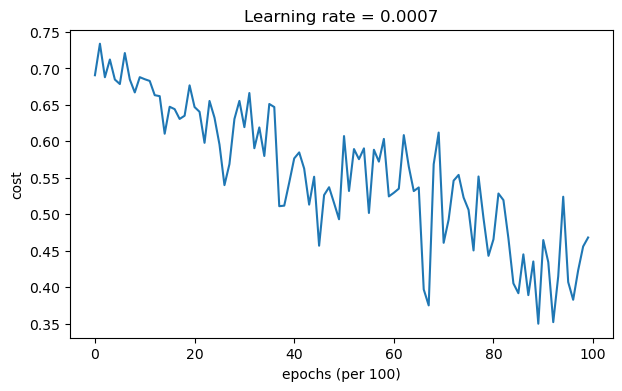

Accuracy: 0.7966666666666666


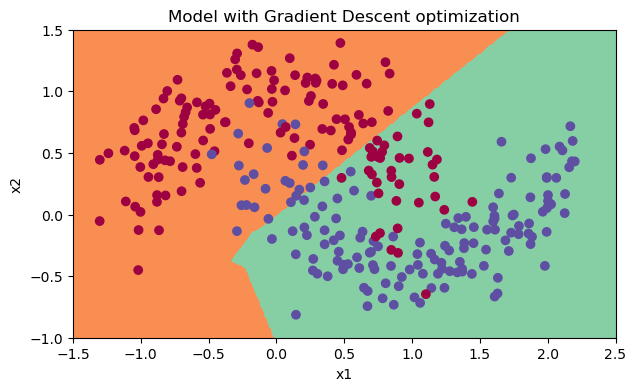

In [26]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "gd")
predictions = predict(train_X, train_Y, parameters)
plt.title("Model with Gradient Descent optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

In [ ]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, beta = 0.9, optimizer = "momentum")
predictions = predict(train_X, train_Y, parameters)
plt.title("Model with Momentum optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

Cost after epoch 0: 0.690741
Cost after epoch 1000: 0.685341
Cost after epoch 2000: 0.647145
Cost after epoch 3000: 0.619594
Cost after epoch 4000: 0.576665
Cost after epoch 5000: 0.607324
Cost after epoch 6000: 0.529476
Cost after epoch 7000: 0.460936
Cost after epoch 8000: 0.465780
